# Picking phas to reduce HRC background

In [1]:
#source /export/ciao/bin/ciao.bash -o
PFILES="./param;$ASCDS_INSTALL/param:$ASCDS_INSTALL/contrib/param"
mkdir -p ./param
ASCDS_WORK_PATH=./

In [2]:
/bin/rm -rf 9700
download_chandra_obsid 9700 evt2,asol,bpix,dtf
mv -f 9700/*/*fits.gz .
gunzip -f *fits.gz
/bin/rm -rf 9700
/bin/ls


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt2     fits       43 Mb  ####################          < 1 s  47839.3 kb/s
  asol     fits        1 Mb  ####################          < 1 s  34694.0 kb/s
  dtf      fits       69 Kb  ####################          < 1 s  4167.2 kb/s
  dtf      fits        3 Kb  ####################          < 1 s  178.9 kb/s
  bpix     fits        3 Kb  ####################          < 1 s  248.4 kb/s

      Total download size for ObsId 9700 = 44 Mb
      Total download time for ObsId 9700 = < 1 s

9700_arf.fits			     hrci_bg_spectra.ipynb
9700_asphist.fits		     hrci_bg_spectra.sh
bkg.reg				     limits.png
doit.py				     param
hard_model.png			     pcadf09700_000N001_asol1.fits
hrcf09700N005_evt2.fits		     pi_bgcdf.png
hrcf09700_000N005_bpix1.fits	     pi_hcdf.png
hrcf09700_000N005_dtf1.fits	     pi_scdf.png
hrcf09700_000N005_std_dtfstat1.f

## Find RMF, Create ARF

### Lookup RMF

In [3]:
dmlist hrcf09700N005_evt2.fits"[cols pi]" cols

 
--------------------------------------------------------------------------------
Columns for Table Block EVENTS
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   pi                   chan         Int2           0:1023               Pulse Invariant


In [4]:
calquiz infile=hrcf09700N005_evt2.fits prod=MATRIX cal="CALDB(TLMAX=1023)" echo=yes

/export/CIAOT/ciaot_install/20211019/ciao-4.14/CALDB/data/chandra/hrc/rmf/hrciD1999-07-22samprmfN0002.fits[2]


In [5]:
pget calquiz outfile | cut -d "[" -f1 | xargs -I@ cp -fv @ rmf.fits 

'/export/CIAOT/ciaot_install/20211019/ciao-4.14/CALDB/data/chandra/hrc/rmf/hrciD1999-07-22samprmfN0002.fits' -> 'rmf.fits'
removed 'rmf.fits'


### Create ARF

In [6]:
asphist infile=pcadf09700_000N001_asol1.fits \
  outfile=9700_asphist.fits \
  evtfile=hrcf09700N005_evt2.fits dtffile=hrcf09700_000N005_dtf1.fits clob+

# asphist (CIAO 4.14): WARNING: skipping 69 livetime correction records (from time: 322753768.640834 to time: 322753908.040841)




In [7]:
pset ardlib AXAF_HRC-I_BADPIX_FILE=hrcf09700_000N005_bpix1.fits

In [8]:
mkarf "9700_asphist.fits[ASPHIST]" 9700_arf.fits \
      sourcepixelx=16384.5 sourcepixely=16384.5 \
      engrid="grid(rmf.fits[cols ENERG_LO,ENERG_HI])" \
      obsfile=hrcf09700N005_evt2.fits detsubsys=HRC-I mode=h clob+

## Find background spectrum files


In [9]:
ls -1 $CALDB/data/chandra/hrc/pibgspec/

hrciD1999-10-04pibgspecN0001.fits
hrciD2000-12-12pibgspecN0001.fits
hrciD2002-01-26pibgspecN0001.fits
hrciD2003-02-22pibgspecN0001.fits
hrciD2004-11-25pibgspecN0001.fits
hrciD2005-10-17pibgspecN0001.fits
hrciD2006-09-20pibgspecN0001.fits
hrciD2007-09-17pibgspecN0001.fits
hrciD2008-09-07pibgspecN0001.fits
hrciD2009-09-24pibgspecN0001.fits
hrciD2010-09-25pibgspecN0001.fits
hrciD2011-09-19pibgspecN0001.fits
hrciD2012-09-27pibgspecN0001.fits
hrciD2013-09-16pibgspecN0001.fits
hrciD2014-09-16pibgspecN0001.fits
hrciD2015-09-27pibgspecN0001.fits
hrciD2016-09-20pibgspecN0001.fits
hrciD2017-09-17pibgspecN0001.fits
hrciD2018-09-17pibgspecN0001.fits


In [10]:
hrc_bkgrnd_lookup hrcf09700N005_evt2.fits spectrum

/export/CIAOT/ciaot_install/20211019/ciao-4.14/CALDB/data/chandra/hrc/pibgspec/hrciD2007-09-17pibgspecN0001.fits


In [11]:
pget hrc_bkgrnd_lookup outfile | xargs -I@ cp -fv @ ./

'/export/CIAOT/ciaot_install/20211019/ciao-4.14/CALDB/data/chandra/hrc/pibgspec/hrciD2007-09-17pibgspecN0001.fits' -> './hrciD2007-09-17pibgspecN0001.fits'
removed './hrciD2007-09-17pibgspecN0001.fits'


In [12]:
cat << EOM > doit.py
import numpy as np
import matplotlib.pylab as plt
from sherpa.astro.ui import *

load_data("hrciD2007-09-17pibgspecN0001.fits")
d = get_data()
pi = d.channel-1.0
bgcumul = np.cumsum(d.counts)
bgcdf = bgcumul * 1.0 / bgcumul[-1]

plt.figure(1)
plt.plot(pi, bgcdf, marker="None")
plt.xlabel("PI")
plt.ylabel(r"$\Sigma$ (counts $\leq$ PI) / $\Sigma$ (counts)")
plt.title(d.name.split("/")[-1])

plt.savefig("pi_bgcdf.png")

# ----------
# Figure 2

load_arf("9700_arf.fits")
load_rmf("rmf.fits")
set_analysis("channel")
set_source(xswabs.abs1*powlaw1d.pl)
abs1.NH = 0.001
pl.gamma = 2.5

plt.figure(2)
plot_model(overplot=False)

plt.savefig("soft_model.png")

# -------------
# Figure 3

scumul = np.cumsum(get_model_plot().y)
scdf = scumul / max(scumul)

plt.figure(1)
plt.plot(pi,scdf, marker="None", color="red")

plt.savefig("pi_scdf.png")

# -----------------
# Figure 4

abs1.nh = 10
pl.gamma = 1

plt.figure(2)
plot_model(overplot=True,clearwindow=False)

plt.savefig("hard_model.png")

# ----
# Figure 5

hcumul = np.cumsum(get_model_plot().y)
hcdf = hcumul / max(hcumul)

plt.figure(1)
plt.plot(pi,hcdf, marker="None", color="blue")
plt.savefig("pi_hcdf.png")



# ----
# Figure 6

xfrac = 0.05
pimin = np.interp(xfrac/2, scdf, pi)
pimax = np.interp(1-xfrac/2, hcdf, pi)
lo = int(pimin)
hi = int(pimax) + 1

print ("PI range: %d to %d" % (lo,hi))

plt.axvline(lo, color="green")
plt.axvline(hi, color="green")
plt.savefig("limits.png")

### -- Fin

blo = np.interp(lo, pi, bgcdf)
bhi = 1.0 - np.interp(hi, pi, bgcdf)
bfrac = bhi + blo

print("Fraction of background excluded is %g" % bfrac)

EOM

python doit.py



**************************************************************
The wabs model is obsolete and is only included for comparison
with historical results. The tbabs model should be used for
the ISM or phabs for general photoelectric absorption.
**************************************************************
PI range: 48 to 293
Fraction of background excluded is 0.245608


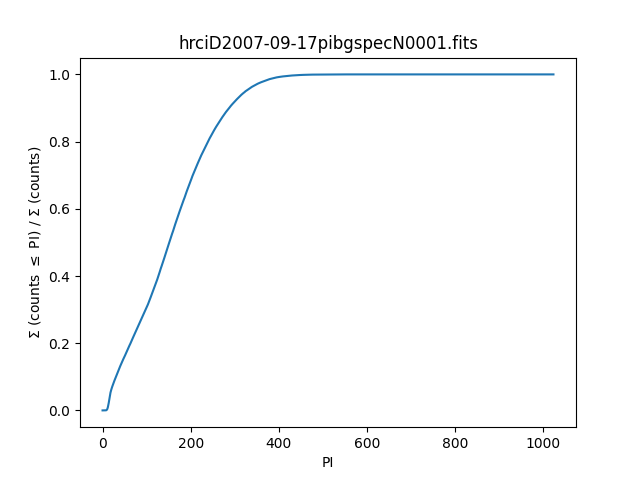

In [13]:
display < pi_bgcdf.png

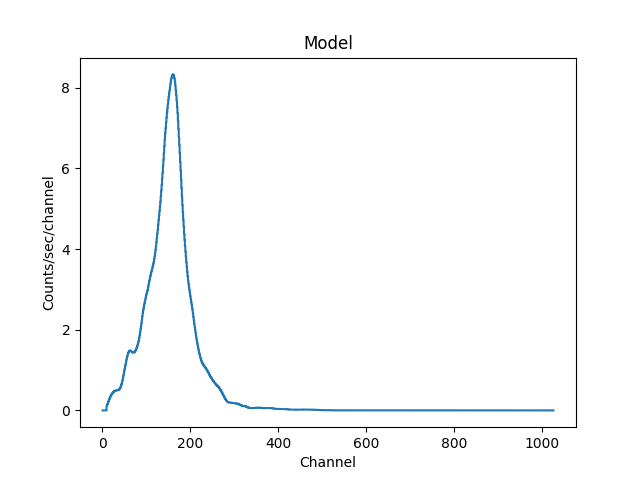

In [14]:
display < soft_model.png

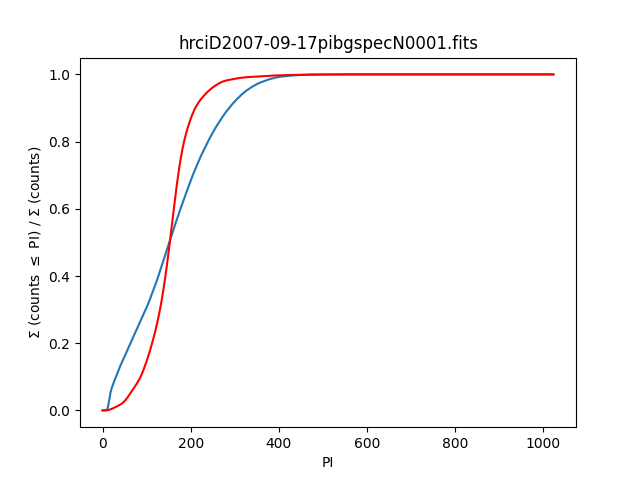

In [15]:
display < pi_scdf.png


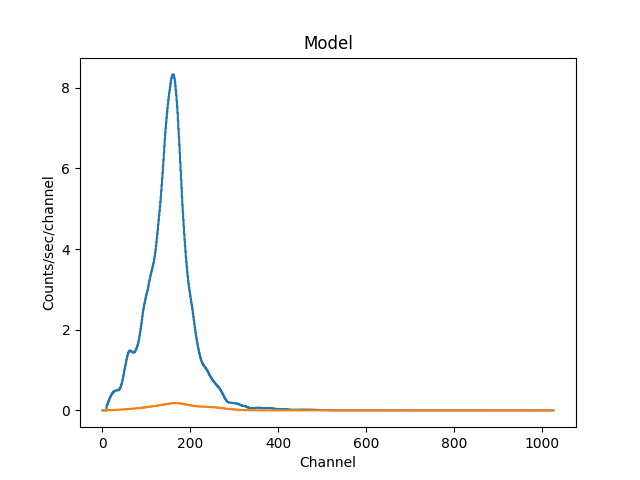

In [16]:
display < hard_model.png

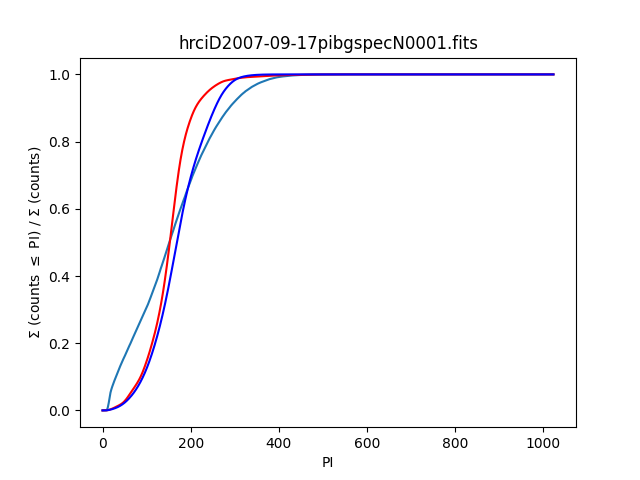

In [17]:
display < pi_hcdf.png

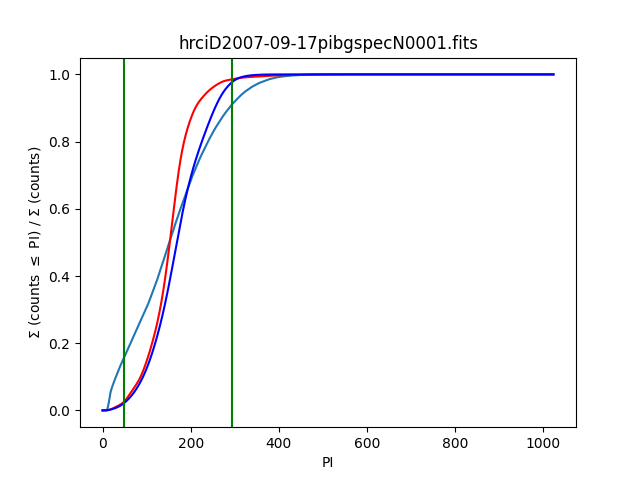

In [18]:
display < limits.png

## Apply


In [19]:
dmcopy "hrcf09700N005_evt2.fits[pi=47:293]" hrcf09700_evt2_pi_flt.fits clob+


In [20]:
cat << EOM > bkg.reg
# Region file format: CIAO version 1.0
annulus(16368.483,16336.472,2731.4111,4097.1167)
EOM


In [21]:
dmstat "hrcf09700N005_evt2.fits[sky=region(bkg.reg)][cols pi]" ver=0
pget dmstat out_good

54798


In [22]:
dmstat "hrcf09700_evt2_pi_flt.fits[sky=region(bkg.reg)][cols pi]" ver=0
pget dmstat out_good

42700


# Cleanup


In [23]:
/bin/rm -f hrcf09700N005_evt2.fits pcadf09700_000N001_asol1.fits